# Emotion detector model and Tflite version for edge devices

The dataset is scrapped from google images and is then used for training the model

# Importing Libraries

In [69]:

import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model,Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dropout
from sklearn.metrics import accuracy_score
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sys import getsizeof
import cv2
import imghdr
import pathlib

# Defining Functions

In [2]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size
     

In [3]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')
     

# ML Model Creation

In [4]:
data_dir = 'data' 

In [5]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [6]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [7]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [8]:
data_iterator = data.as_numpy_iterator()

In [9]:
batch = data_iterator.next()

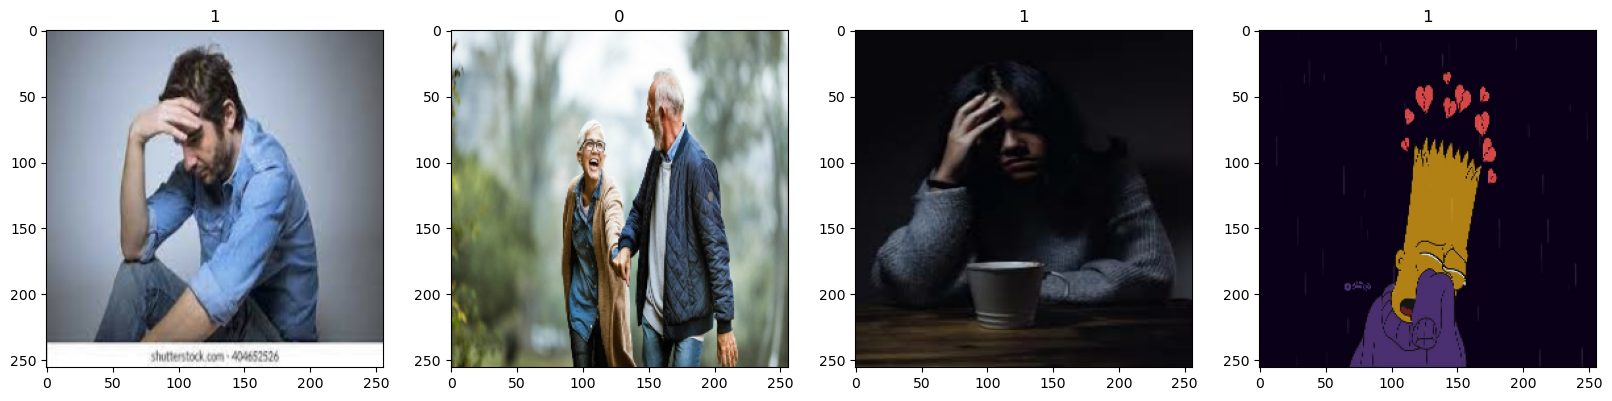

In [10]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [11]:
data = data.map(lambda x,y: (x/255, y))

In [12]:
data.as_numpy_iterator().next()

(array([[[[9.60784316e-01, 9.76470590e-01, 9.72549021e-01],
          [9.60784316e-01, 9.76470590e-01, 9.72549021e-01],
          [9.60784316e-01, 9.76470590e-01, 9.72549021e-01],
          ...,
          [9.60784316e-01, 9.76470590e-01, 9.72549021e-01],
          [9.60784316e-01, 9.76470590e-01, 9.72549021e-01],
          [9.60784316e-01, 9.76470590e-01, 9.72549021e-01]],
 
         [[9.60784316e-01, 9.76470590e-01, 9.72549021e-01],
          [9.60784316e-01, 9.76470590e-01, 9.72549021e-01],
          [9.60784316e-01, 9.76470590e-01, 9.72549021e-01],
          ...,
          [9.60784316e-01, 9.76470590e-01, 9.72549021e-01],
          [9.60784316e-01, 9.76470590e-01, 9.72549021e-01],
          [9.60784316e-01, 9.76470590e-01, 9.72549021e-01]],
 
         [[9.60784316e-01, 9.76470590e-01, 9.72549021e-01],
          [9.60784316e-01, 9.76470590e-01, 9.72549021e-01],
          [9.60784316e-01, 9.76470590e-01, 9.72549021e-01],
          ...,
          [9.60784316e-01, 9.76470590e-01, 9.7254

In [13]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [14]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [15]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [16]:
model = Sequential()

In [17]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [18]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [20]:
logdir='logs'

In [21]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [22]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 6s 298ms/step - loss: 0.9341 - accuracy: 0.4688 - val_loss: 0.6971 - val_accuracy: 0.5156
Epoch 2/20
7/7 [==============================] - 4s 330ms/step - loss: 0.6489 - accuracy: 0.5223 - val_loss: 0.6180 - val_accuracy: 0.5781
Epoch 3/20
7/7 [==============================] - 3s 295ms/step - loss: 0.5666 - accuracy: 0.7143 - val_loss: 0.5027 - val_accuracy: 0.7969
Epoch 4/20
7/7 [==============================] - 3s 302ms/step - loss: 0.4175 - accuracy: 0.8259 - val_loss: 0.3053 - val_accuracy: 0.8750
Epoch 5/20
7/7 [==============================] - 3s 308ms/step - loss: 0.3012 - accuracy: 0.8884 - val_loss: 0.2213 - val_accuracy: 0.9531
Epoch 6/20
7/7 [==============================] - 3s 298ms/step - loss: 0.2410 - accuracy: 0.9375 - val_loss: 0.1577 - val_accuracy: 0.9531
Epoch 7/20
7/7 [==============================] - 3s 297ms/step - loss: 0.2175 - accuracy: 0.9241 - val_loss: 0.1422 - val_accuracy: 0.9844
Epoch 8/20
7/7 [====

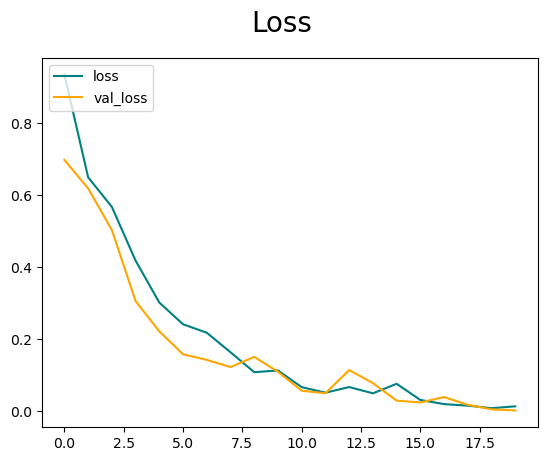

In [23]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

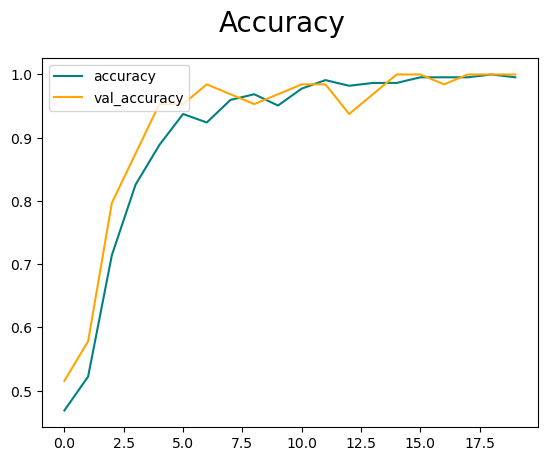

In [24]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Testing the model

In [25]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

# Get the final results
precision_result = pre.result().numpy()
recall_result = re.result().numpy()
accuracy_result = acc.result().numpy()

# Print the results
print("Accuracy:", accuracy_result)
print("Precision:", precision_result)
print("Recall:", recall_result)

1/1 [==============================] - 1s 521ms/step
Accuracy: 1.0
Precision: 1.0
Recall: 1.0


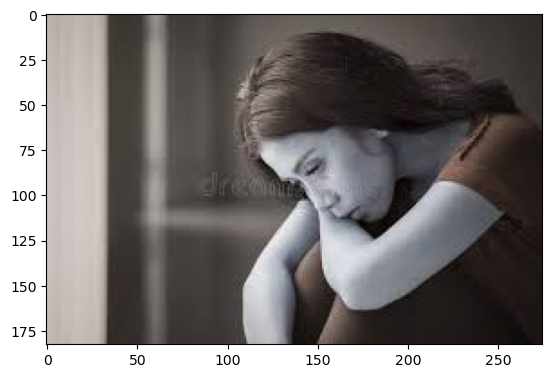

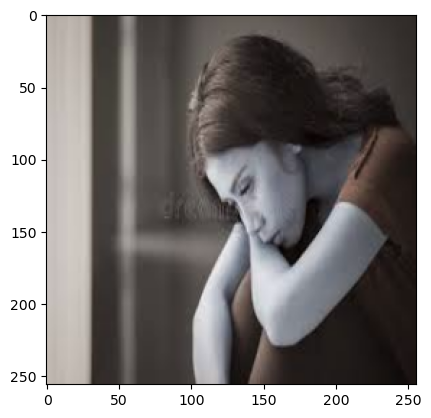

In [26]:
# Load the image using OpenCV
img = cv2.imread('sad_test.jpg')

plt.imshow(img)
plt.show()

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()


In [27]:
result = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 102ms/step


In [28]:
result


array([[0.9990477]], dtype=float32)

In [29]:
if result > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


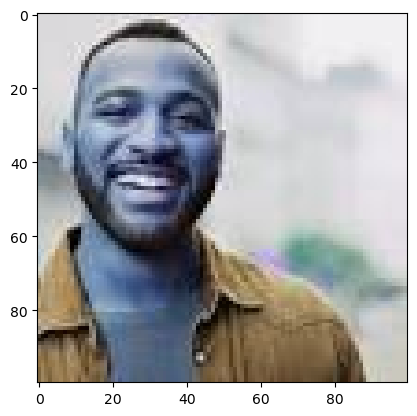

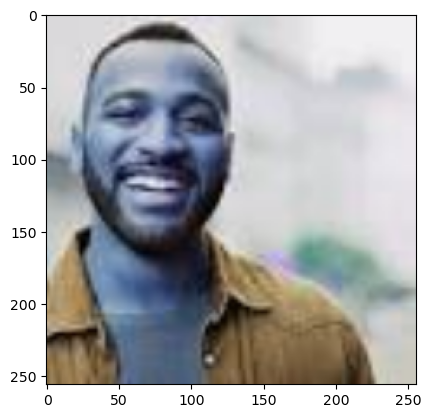

In [30]:
# Load the image using OpenCV
img = cv2.imread('happy_test.jpg')

plt.imshow(img)
plt.show()

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()


In [31]:
result = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 17ms/step


In [32]:
result

array([[0.08620903]], dtype=float32)

In [33]:
if result > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


In [34]:
model.save(os.path.join('models','SadUnsad.h5'))

In [35]:
new_model = load_model('models/SadUnsad.h5')

In [36]:
convert_bytes(get_file_size('models/SadUnsad.h5'), "MB")

File size: 42.355 Megabytes


# Tflite conversion

In [37]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"

In [38]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = tf_lite_converter.convert()
     

INFO:tensorflow:Assets written to: C:\Users\Paras\AppData\Local\Temp\tmptyubqarq\assets


INFO:tensorflow:Assets written to: C:\Users\Paras\AppData\Local\Temp\tmptyubqarq\assets


In [39]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)
     

14790588

In [40]:
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "MB")

File size: 14.105 Megabytes


In [50]:

interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 256 256   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 1]
Output Type: <class 'numpy.float32'>


In [55]:
interpreter.resize_tensor_input(input_details[0]['index'], (1000, 256, 256,3))
interpreter.resize_tensor_input(output_details[0]['index'], (1000, 10))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])
     

Input Shape: [1000  256  256    3]
Input Type: <class 'numpy.float32'>
Output Shape: [1000    1]
Output Type: <class 'numpy.float32'>


In [56]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

# Get the final results
precision_result = pre.result().numpy()
recall_result = re.result().numpy()
accuracy_result = acc.result().numpy()

# Print the results
print("Accuracy:", accuracy_result)
print("Precision:", precision_result)
print("Recall:", recall_result)

1/1 [==============================] - 0s 24ms/step
Accuracy: 0.9411765
Precision: 0.875
Recall: 1.0


In [73]:
for file in pathlib.Path('data').iterdir():
    print("File Path:", file.resolve())
    # Read and resize the image...

File Path: C:\Users\Paras\6 sem\Ai HT\TinyMl\data\happy
File Path: C:\Users\Paras\6 sem\Ai HT\TinyMl\data\sad


# Testing the Tflite Model

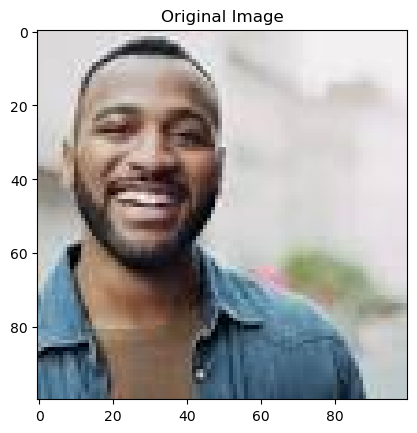

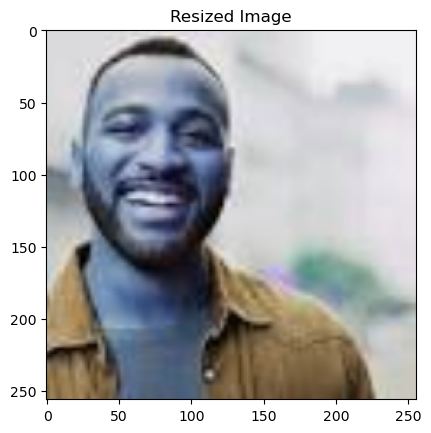

Prediction for happy_test.jpg: Class 1


In [87]:

# Load TFLite model
model_path = 'tf_lite_model.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess image
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((256, 256))  # Replace with the input size of your model
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image

# Function to make predictions
def predict_image(image_path):
    input_data = preprocess_image(image_path)
    input_data = tf.expand_dims(input_data, axis=0)

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

# Load image using OpenCV
img_path = 'happy_test.jpg'
img = cv2.imread(img_path)

# Display the original image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.show()

# Resize using TensorFlow
resize = tf.image.resize(tf.convert_to_tensor(img), (256, 256)).numpy().astype(int)

# Display the resized image
plt.imshow(resize)
plt.title("Resized Image")
plt.show()

# Predict using the TFLite model
prediction = predict_image(img_path)
predicted_class = int(prediction[0][0])  # Assuming a single output class, adjust if needed

print(f"Prediction for {img_path}: Class {predicted_class}")


In [88]:
result = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 19ms/step


In [89]:
result

array([[0.08366012]], dtype=float32)

In [90]:
if result > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


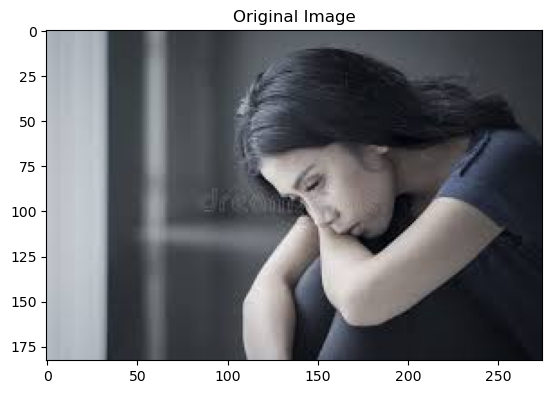

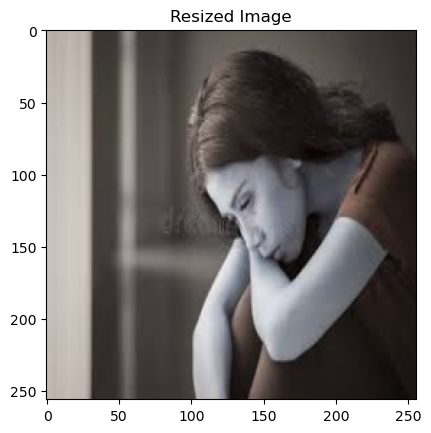

Prediction for sad_test.jpg: Class 1


In [91]:
img_path = 'sad_test.jpg'
img = cv2.imread(img_path)

# Display the original image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.show()

# Resize using TensorFlow
resize = tf.image.resize(tf.convert_to_tensor(img), (256, 256)).numpy().astype(int)

# Display the resized image
plt.imshow(resize)
plt.title("Resized Image")
plt.show()

# Predict using the TFLite model
prediction = predict_image(img_path)
predicted_class = int(prediction[0][0])  # Assuming a single output class, adjust if needed

print(f"Prediction for {img_path}: Class {predicted_class}")


In [92]:
result = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 17ms/step


In [93]:
result

array([[0.99911946]], dtype=float32)

In [94]:
if result > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# Conclusion

Hence, the Model is now finalized and deployable for edge devices for remote usage